In [12]:
# 0 install
# !pip install pystan==2.18.0.0
# !pip install fbprophet

In [13]:
import pandas as pd
from fbprophet import Prophet

In [21]:
# 1 preparation( read data)
_df = pd.read_csv('https://www.tepco.co.jp/forecast/html/images/juyo-2017.csv', encoding='shift-jis', skiprows=1)

In [22]:
_df.head()

,DATE,TIME,実績(万kW)
0,2017/1/1,0:00,2783
1,2017/1/1,1:00,2634
2,2017/1/1,2:00,2520
3,2017/1/1,3:00,2438
4,2017/1/1,4:00,2389


In [23]:
_df.shape

(8760, 3)

In [41]:
years = [2017, 2018, 2019]

df = pd.DataFrame()
for year in years:
   _df = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv', encoding='shift-jis', skiprows=1)
   df = pd.concat([df, _df], axis=0)

In [42]:
df.head(), df.tail(), df.shape

(       DATE  TIME  実績(万kW)
 0  2017/1/1  0:00     2783
 1  2017/1/1  1:00     2634
 2  2017/1/1  2:00     2520
 3  2017/1/1  3:00     2438
 4  2017/1/1  4:00     2389,
             DATE   TIME  実績(万kW)
 8755  2019/12/31  19:00     3302
 8756  2019/12/31  20:00     3263
 8757  2019/12/31  21:00     3182
 8758  2019/12/31  22:00     3077
 8759  2019/12/31  23:00     3029,
 (26280, 3))

In [43]:
# 2 preprocessing
# reset index
df = df.reset_index(drop=True)

In [44]:
# date + time into datetime
date = df['DATE'][0]
time = df['TIME'][0]
str_datetime = f'{date} {time}'
str_datetime

'2017/1/1 0:00'

In [45]:
from datetime import datetime as dt

In [46]:
datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
datetime

datetime.datetime(2017, 1, 1, 0, 0)

In [47]:
datetimes = []

for index, datum in df.iterrows():
   date = datum['DATE']
   time = datum['TIME']
   str_datetime = f'{date} {time}'
   datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
   datetimes.append(datetime)

In [48]:
datetimes[:5]

[datetime.datetime(2017, 1, 1, 0, 0),
 datetime.datetime(2017, 1, 1, 1, 0),
 datetime.datetime(2017, 1, 1, 2, 0),
 datetime.datetime(2017, 1, 1, 3, 0),
 datetime.datetime(2017, 1, 1, 4, 0)]

In [49]:
df.head(3)

,DATE,TIME,実績(万kW)
0,2017/1/1,0:00,2783
1,2017/1/1,1:00,2634
2,2017/1/1,2:00,2520


In [51]:
# formatting data for prophet
df['ds'] = datetimes
df = df.rename(columns={'実績(万kW)':'y'})
df.head()

,DATE,TIME,y,ds
0,2017/1/1,0:00,2783,2017-01-01 00:00:00
1,2017/1/1,1:00,2634,2017-01-01 01:00:00
2,2017/1/1,2:00,2520,2017-01-01 02:00:00
3,2017/1/1,3:00,2438,2017-01-01 03:00:00
4,2017/1/1,4:00,2389,2017-01-01 04:00:00


In [52]:
# 3 build a prediction model
# Prophet follows the sklearn model API (Facebook says)
model = Prophet()

In [53]:
model.fit(df)

In [54]:
future = model.make_future_dataframe(24*366, freq='H')
future.tail()

,ds
35059,2020-12-31 19:00:00
35060,2020-12-31 20:00:00
35061,2020-12-31 21:00:00
35062,2020-12-31 22:00:00
35063,2020-12-31 23:00:00


In [55]:
forecast = model.predict(future)

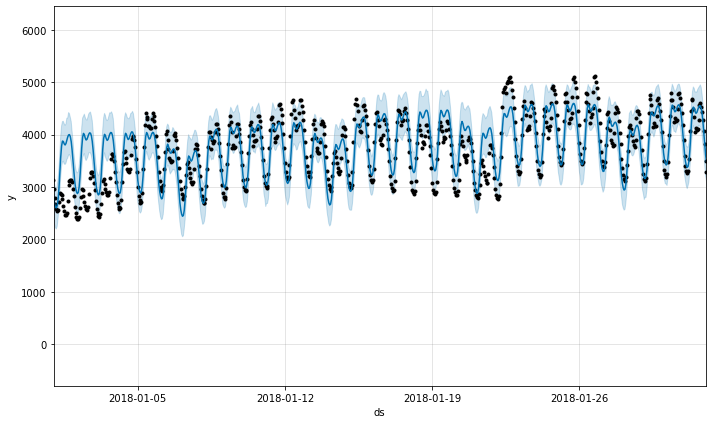

In [56]:
import matplotlib.pyplot as plt

model.plot(forecast)
plt.xlim(dt(2018, 1, 1), dt(2018, 2, 1))
plt.show()

In [70]:
# 4 Aggregation of forecast results
# read teacher data
df_2020 = pd.read_csv('https://www.tepco.co.jp/forecast/html/images/juyo-2020.csv', encoding='shift-jis', skiprows=1)
df_2020 = df_2020.rename(columns={'実績(万kW)': 'y'})
df_2020.head()

,DATE,TIME,y
0,2020/1/1,0:00,2857
1,2020/1/1,1:00,2703
2,2020/1/1,2:00,2602
3,2020/1/1,3:00,2520
4,2020/1/1,4:00,2464


In [71]:
# conditional extraction( filtering)
forecast_2020 = forecast[forecast['ds'] >= dt(2020, 1, 1)].reset_index(drop=True)
forecast_2020.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,3129.232799,2550.053224,3319.071103,3129.232799,3129.232799,-221.101682,-221.101682,-221.101682,-488.418096,...,108.739137,108.739137,108.739137,158.577277,158.577277,158.577277,0.0,0.0,0.0,2908.131117
1,2020-01-01 01:00:00,3129.187280,2394.891917,3170.807780,3129.187280,3129.187280,-350.791369,-350.791369,-350.791369,-617.310869,...,108.085489,108.085489,108.085489,158.434011,158.434011,158.434011,0.0,0.0,0.0,2778.395911
2,2020-01-01 02:00:00,3129.141761,2325.059549,3050.359211,3129.141761,3129.141761,-428.410077,-428.410077,-428.410077,-694.377052,...,107.670179,107.670179,107.670179,158.296796,158.296796,158.296796,0.0,0.0,0.0,2700.731684


In [72]:
# comparison
results = pd.DataFrame()
# Measured value
results['t'] = df_2020['y']
# Predicted value
results['y'] = forecast_2020['yhat']

results['diff'] = results['t'] - results['y']

results.head()

,t,y,diff
0,2857,2908.131117,-51.131117
1,2703,2778.395911,-75.395911
2,2602,2700.731684,-98.731684
3,2520,2666.786866,-146.786866
4,2464,2686.472423,-222.472423


In [73]:
# MAPE( Mean Absolute Percent Error)
import numpy as np

In [74]:
np.mean(abs(results['diff']/results['t'])*100)

10.521755055847116

In [75]:
# advanced
# improve accuracy with more data
df_holidays = pd.read_csv('holidays+hotdays+hour_2017_2019.csv')
df_holidays.head()

,ds,holiday,lower_window,upper_window
0,2017/01/01 0:00:00,holiday,0,1
1,2017/01/01 1:00:00,holiday,0,1
2,2017/01/01 10:00:00,holiday,0,1
3,2017/01/01 11:00:00,holiday,0,1
4,2017/01/01 12:00:00,holiday,0,1


In [76]:
# set capacity( tempolary value): limitation
df.y.max()

5653

In [77]:
df['cap'] = 5700

In [79]:
model = Prophet(
   growth='logistic',
   yearly_seasonality=True,
   weekly_seasonality=True,
   daily_seasonality=True,
   holidays=df_holidays
)

In [80]:
model.fit(df)

In [81]:
future['cap'] = 5700
forecast = model.predict(future)

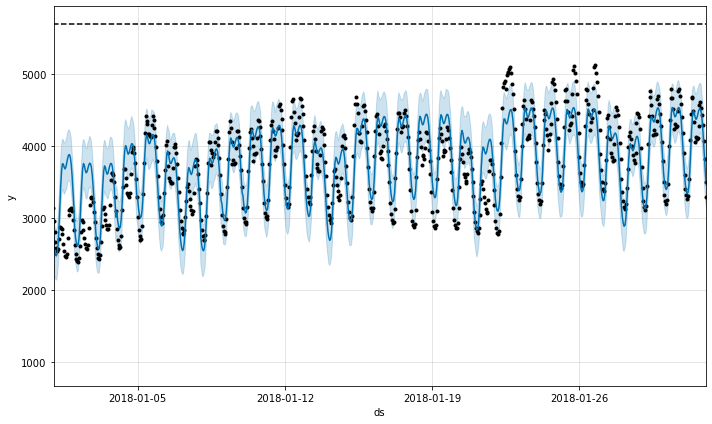

In [82]:
model.plot(forecast)
plt.xlim(dt(2018, 1, 1), dt(2018, 2, 1))
plt.show()

In [83]:
# conditional extraction
forecast_2020 = forecast[forecast['ds'] >= dt(2020, 1, 1)].reset_index(drop=True)

# comparison
results = pd.DataFrame()
# Measured value
results['t'] = df_2020['y']
# Predicted value
results['y'] = forecast_2020['yhat']
# diff
results['diff'] = results['t'] - results['y']

# MAPE
np.mean(abs(results['diff']/results['t'])*100)

8.85246864110035

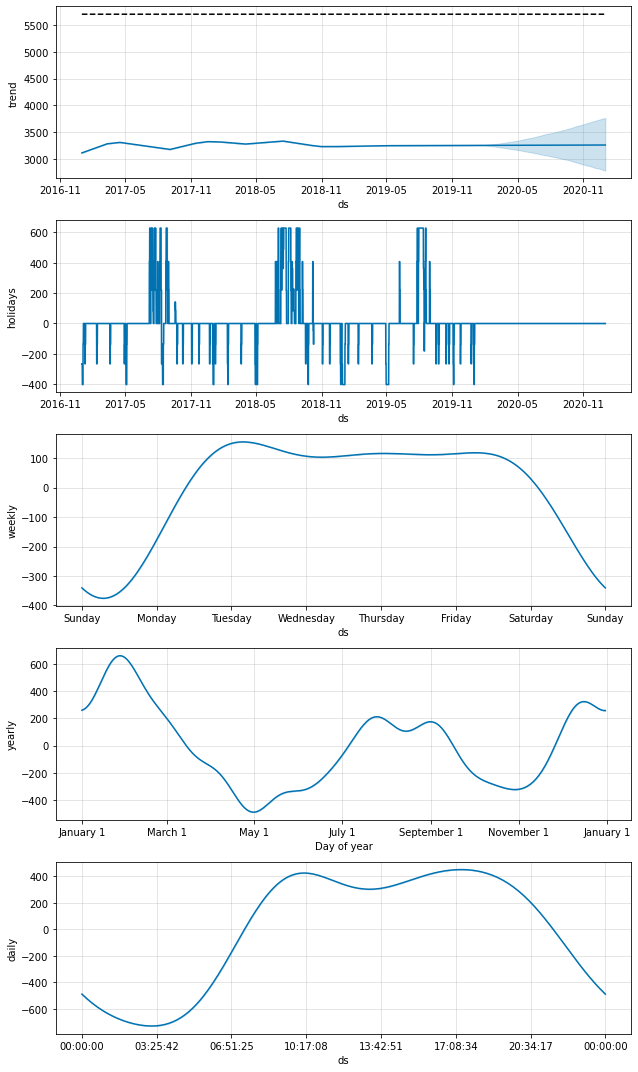

In [84]:
# Confirmation of periodicity
model.plot_components(forecast)
plt.show()